In [1]:
%load_ext autoreload
%autoreload

import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
from joblib import dump, load
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

sys.path.append('../../utils')
from utils import feature_selection, thomas_parser, PCA_reduction, perf, time_comparison
from toBoolean import convert

# Parameters tuning

In [3]:
gt = pd.read_csv('../../../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

### Criterion

Measures the quality of a split. Two techniques are available : "*gini*" for the Gini impurty (default) and "*entropy*" for information gain.

In [4]:
for i in ["gini","entropy"]:
    print("Criterion : %s" % i)
    tree = DecisionTreeClassifier(criterion=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Criterion : gini
Accuracy on training set: 1.000
Accuracy on test set: 0.869
Criterion : entropy
Accuracy on training set: 1.000
Accuracy on test set: 0.872


We're clearly overfitting, nevertheless the *entropy* criteria seems to give slightly better results. Overfitting can be solved by limiting the depth of the tree (explained more deeply in a following section).

In [5]:
for i in ["gini","entropy"]:
    print("Criterion : %s" % i)
    tree = DecisionTreeClassifier(max_depth=4,criterion=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Criterion : gini
Accuracy on training set: 0.924
Accuracy on test set: 0.923
Criterion : entropy
Accuracy on training set: 0.917
Accuracy on test set: 0.922


In this case, the default configuration gives better results.

#### Splitter

The strategy used to choose the split at each node. Supported strategies are “*best*” to choose the best split (default) and “*random*” to choose the best random split. (N.B: we also apply depth limitation to avoid overfitting)

In [6]:
for i in ["best","random"]:
    print("Split strategy : %s" % i)
    tree = DecisionTreeClassifier(max_depth=4,splitter=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Split strategy : best
Accuracy on training set: 0.924
Accuracy on test set: 0.923
Split strategy : random
Accuracy on training set: 0.895
Accuracy on test set: 0.900


Looks like keeping the default splitter is also better in the case of this dataset.

#### Depth

Limiting the depth of the tree decreases overfitting. This leads to a lower accuracy on the training set, but an improvement on the test set:

In [7]:
for i in range(1,10):
    print("Depth set to %s" % i)
    tree = DecisionTreeClassifier(max_depth=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Depth set to 1
Accuracy on training set: 0.895
Accuracy on test set: 0.900
Depth set to 2
Accuracy on training set: 0.912
Accuracy on test set: 0.915
Depth set to 3
Accuracy on training set: 0.918
Accuracy on test set: 0.915
Depth set to 4
Accuracy on training set: 0.924
Accuracy on test set: 0.923
Depth set to 5
Accuracy on training set: 0.930
Accuracy on test set: 0.919
Depth set to 6
Accuracy on training set: 0.935
Accuracy on test set: 0.917
Depth set to 7
Accuracy on training set: 0.941
Accuracy on test set: 0.911
Depth set to 8
Accuracy on training set: 0.945
Accuracy on test set: 0.911
Depth set to 9
Accuracy on training set: 0.951
Accuracy on test set: 0.908


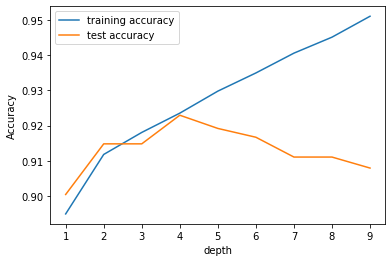

In [8]:
training_accuracy = [] 
test_accuracy = []
settings = range(1, 10)
for v in settings:
    clf = DecisionTreeClassifier(max_depth=v, random_state=0) 
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("depth")
plt.legend()

As we can see, increasing the depth value improves the accuracy of the training set but not necessarily of the test set. The best result we get is at depth 4, which offers a good compromise between the two accuracies.

#### Minimum number of samples (split)

*min_samples_split* represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node.

In [10]:
for i in range(1,11):
    n_samples = i/10
    print("min_samples_split set to %s" % n_samples)
    tree = DecisionTreeClassifier(min_samples_split=n_samples, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

min_samples_split set to 0.1
Accuracy on training set: 0.915
Accuracy on test set: 0.898
min_samples_split set to 0.2
Accuracy on training set: 0.896
Accuracy on test set: 0.886
min_samples_split set to 0.3
Accuracy on training set: 0.895
Accuracy on test set: 0.898
min_samples_split set to 0.4
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 0.5
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 0.6
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 0.7
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 0.8
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 0.9
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 1.0
Accuracy on training set: 0.895
Accuracy on test set: 0.900


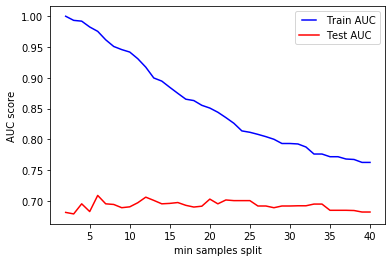

In [11]:
min_samples_splits = range(2,41)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=0)
   dt.fit(data_train, target_train)
   train_pred = dt.predict(data_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(data_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

In [12]:
for i in range(2,11):
    print("min_samples_split set to %s" % i)
    tree = DecisionTreeClassifier(min_samples_split=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

min_samples_split set to 2
Accuracy on training set: 1.000
Accuracy on test set: 0.869
min_samples_split set to 3
Accuracy on training set: 0.999
Accuracy on test set: 0.870
min_samples_split set to 4
Accuracy on training set: 0.997
Accuracy on test set: 0.879
min_samples_split set to 5
Accuracy on training set: 0.995
Accuracy on test set: 0.872
min_samples_split set to 6
Accuracy on training set: 0.991
Accuracy on test set: 0.878
min_samples_split set to 7
Accuracy on training set: 0.988
Accuracy on test set: 0.879
min_samples_split set to 8
Accuracy on training set: 0.984
Accuracy on test set: 0.872
min_samples_split set to 9
Accuracy on training set: 0.982
Accuracy on test set: 0.883
min_samples_split set to 10
Accuracy on training set: 0.981
Accuracy on test set: 0.880


#### Minimum number of samples (leaf)

*min_samples_leaf* is the minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples at the leafs, the base of the tree.

In [13]:
for i in range(2,11):
    print("min_samples_split set to %s" % i)
    tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

min_samples_split set to 2
Accuracy on training set: 0.986
Accuracy on test set: 0.885
min_samples_split set to 3
Accuracy on training set: 0.978
Accuracy on test set: 0.876
min_samples_split set to 4
Accuracy on training set: 0.971
Accuracy on test set: 0.881
min_samples_split set to 5
Accuracy on training set: 0.966
Accuracy on test set: 0.885
min_samples_split set to 6
Accuracy on training set: 0.962
Accuracy on test set: 0.885
min_samples_split set to 7
Accuracy on training set: 0.953
Accuracy on test set: 0.887
min_samples_split set to 8
Accuracy on training set: 0.948
Accuracy on test set: 0.887
min_samples_split set to 9
Accuracy on training set: 0.945
Accuracy on test set: 0.883
min_samples_split set to 10
Accuracy on training set: 0.941
Accuracy on test set: 0.899


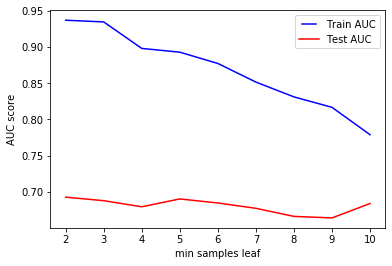

In [14]:
settings = range(2,11)
train_results = []
test_results = []
for v in settings:
   dt = DecisionTreeClassifier(min_samples_leaf=v, random_state=0)
   dt.fit(data_train, target_train)
   train_pred = dt.predict(data_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(data_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(settings, train_results, 'b', label="Train AUC")
line2, = plt.plot(settings, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

#### Number of features

*max_features* represents the number of features to consider when looking for the best split. Since we're working with 119 different features, let's try all the values and see how relevant they are.

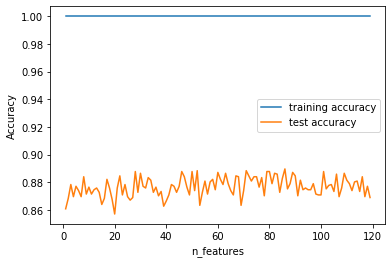

In [15]:
training_accuracy = [] 
test_accuracy = []
settings = range(1, 120)
for f in settings:
    clf = DecisionTreeClassifier(max_features=f, random_state=0) #n_jobs means that we use all processors
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_features")
plt.legend()

As we can see from the graph, not all features are important in making the classification. Further selection on relevant features will be made.

### Final choice

In [16]:
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.913
Accuracy on test set: 0.910
